In [ ]:
import torch
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_farthest_points, sample_points_from_meshes, knn_points
from pytorch3d.structures import Meshes


def bbox_normalize(points: torch.Tensor, isotropic: bool = False):
    """
        points
    """
    points_min, points_max = points.min(dim=0)[0], points.max(dim=0)[0]
    if isotropic:
        points = 2 * (points - points_min) / (points_max - points_min) - 1
    else:
        points = 2 * (points - points_min) / \
            (points_max - points_min).max() - 1

    return points


def normalize(points: torch.Tensor, isotropic: bool = False):
    """
        points
    """
    points_min, points_max = points.min(dim=0)[0], points.max(dim=0)[0]
    if isotropic:
        points = 2 * (points - points_min) / (points_max - points_min) - 1
    else:
        points = 2 * (points - points_min) / \
            (points_max - points_min).max() - 1

    return points

def compute_tsdf(mesh_path, 
                 l=32, w=32, h=32, 
                 K=50, 
                 init_samples=10000, use_FPS_reduction:bool=False , fps_samples=5000,
                 trunated_dis:float=0.3):
    """
    流程说明：
    1. 加载网格 -> 2. 表面均匀采样 -> 3. FPS下采样 -> 4. 构建体素 -> 5. K近邻角度判断 -> 6. TSDF计算
    """
    # ----------------------------------
    # 1. 读取网格并归一化到[-1,1]立方体
    # ----------------------------------
    verts, faces, aux = load_obj(mesh_path)
    faces = faces.verts_idx
    verts = normalize(verts, isotropic=False)

    mesh = Meshes(verts=[verts], faces=[faces])

    # ----------------------------------
    # 2. 表面均匀采样（使用三角形面积加权）
    # ----------------------------------
    # 首先生成大量初始点（包含法向量）
    dense_points, dense_normals = sample_points_from_meshes(
        mesh,
        num_samples=init_samples,
        return_normals=True
    )  # [1, init_samples, 3], [1, init_samples, 3]

    # # ----------------------------------
    # # 3. FPS下采样获得更均匀分布的点云
    # # ----------------------------------
    
    if use_FPS_reduction:
        fps_points, fps_idx = sample_farthest_points(
            dense_points,
            K=fps_samples,
            random_start_point=True
        )  # [1, fps_samples, 3]
        
        points = fps_points.squeeze(0)  # [fps_samples, 3]
        normals = dense_normals[0, fps_idx[0]]  # [fps_samples, 3]
    else:
        points = dense_points.squeeze(0)  # [fps_samples, 3]
        normals = dense_normals.squeeze(0)  # [fps_samples, 3]

    # ----------------------------------
    # 4. 创建体素网格坐标（与模型同坐标系）
    # ----------------------------------
    voxel_coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, l),
        torch.linspace(-1, 1, w),
        torch.linspace(-1, 1, h),
        indexing="ij"
    ), dim=-1).reshape(-1, 3)  # [l*w*h, 3]

    # ----------------------------------
    # 5. 查找每个体素的K近邻点云
    # ----------------------------------
    knn_result = knn_points(
        voxel_coords.unsqueeze(0),  # 体素坐标需增加batch维度
        points.unsqueeze(0),        # 点云同样增加batch维度
        K=K
    )
    idxs = knn_result.idx[0]  # [l*w*h, K]

    # ----------------------------------
    # 6. 通过法向量夹角判断体素内外
    # ----------------------------------
    # 向量：体素中心 -> 邻近点
    voxel_to_point = voxel_coords.unsqueeze(1) - points[idxs]  # [N, K, 3]

    # 获取邻近点的法向量（指向外部）
    neighbor_normals = normals[idxs]  # [N, K, 3]

    # 计算夹角余弦值（向量方向与法向量方向）
    cos_angles = torch.sum(
        voxel_to_point * neighbor_normals,
        dim=-1
    ) / (torch.norm(voxel_to_point, dim=-1) + 1e-6)  # [N, K]

    # 判断逻辑：若多数角度<90度（cos>0），则体素在外部
    outside_votes = (cos_angles > 0).float().mean(dim=-1)  # [N]
    inside_mask = outside_votes < 0.5  # 投票阈值可调

    # ----------------------------------
    # 7. 计算TSDF值（带符号距离场）
    # ----------------------------------
    # 获取最近距离作为TSDF绝对值
    closest_dists = knn_result.dists[0].min(dim=-1)[0]  # [N]

    # 根据内外标志赋予符号
    tsdf = torch.where(inside_mask, -closest_dists, closest_dists)
    tsdf = tsdf.clamp(min=-trunated_dis, max=trunated_dis)

    # 重塑为3D网格
    tsdf_grid = tsdf.view(l, w, h)

    return tsdf_grid, dense_points

# # 使用示例
# tsdf_grid = compute_tsdf(
#     "model.obj",
#     l=64, w=64, h=64,
#     K=5,
#     init_samples=20000,  # 初始密集采样点数
#     fps_samples=5000     # FPS下采样后点数
# )

In [2]:
import torch
import numpy as np
import skimage
import matplotlib.pyplot as plt
import trimesh
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_farthest_points, knn_points
from pytorch3d.ops.marching_cubes import marching_cubes
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene


def visualize_mesh(mesh, title="Mesh"):
    # 创建可视化场景
    fig = plot_scene({
        title: {
            "mesh": mesh
        }
    })
    fig.update_layout(height=800, width=800)
    return fig.show()


mesh_path = "..\\assets\\models\\benchmark\\019-SUV.obj"
verts, faces, aux = load_obj(mesh_path)
orig_mesh = Meshes(verts=[verts], faces=[faces.verts_idx])
print("显示原始模型...")
visualize_mesh(orig_mesh, "Original Mesh")
tsdf_grid, dense_points = compute_tsdf(
    mesh_path,
    l=64, w=64, h=64,
    K=100,
    init_samples=4096,  # 初始密集采样点数
    fps_samples=2048     # FPS下采样后点数
)

point_cloud = Pointclouds(points=[dense_points.squeeze()])  # 创建点云结构

# 可视化
# fig = plot_scene({
#     "Pointcloud": {
#         "scene": point_cloud
#     }
# })
# fig.update_layout(height=800, width=800)
# fig.show()

print((tsdf_grid > 0).sum())
vertices, faces, normals, _ = skimage.measure.marching_cubes(
    tsdf_grid.cpu().numpy(), gradient_direction='descent', level=0)
# verts, faces = marching_cubes(
#     tsdf_grid.unsqueeze(0),  # 需要batch维度
#     isolevel=0.1,
#     return_local_coords=True
#     )
# vertices = verts[0].numpy()
# faces = faces[0].numpy()
# tsdf_mesh = Meshes(verts=[torch.from_numpy(vertices)],
#                    faces=[torch.from_numpy(faces)])

d:\anaconda3\envs\car_shape_recon\lib\site-packages\pytorch3d-0.7.4-py3.10-win-amd64.egg\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


显示原始模型...


d:\anaconda3\envs\car_shape_recon\lib\site-packages\pytorch3d-0.7.4-py3.10-win-amd64.egg\pytorch3d\io\obj_io.py:544: UserWarning:

No mtl file provided



tensor(239786)


In [3]:
tsdf_mesh = trimesh.Trimesh(vertices, faces)
tsdf_mesh.show()

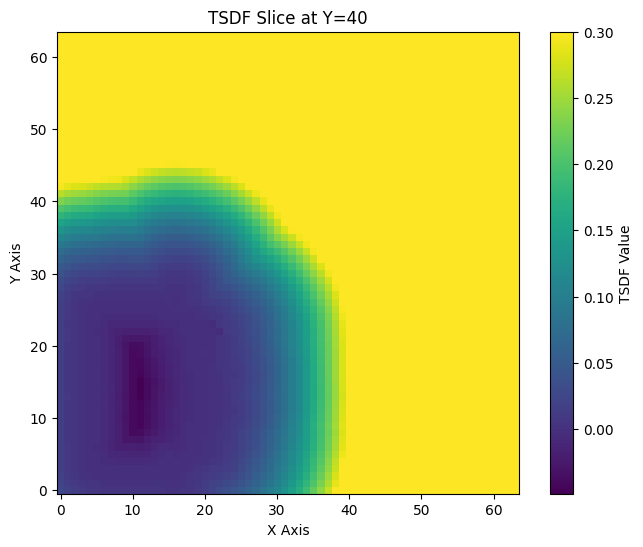

In [4]:
def plot_tsdf_slice(tsdf_slice, title="TSDF Slice", cmap="viridis"):
    """
    绘制 TSDF 切片的二维热力图
    :param tsdf_slice: 2D 张量，TSDF 切片
    :param title: 图像标题
    :param cmap: 颜色映射（默认为 'viridis'）
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(tsdf_slice.cpu().numpy(), cmap=cmap, origin="lower")
    plt.colorbar(label="TSDF Value")
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.show()


slice_index = 40  # 选择 z 轴的中间位置
tsdf_slice = tsdf_grid[:, :, slice_index]
# 绘制热力图
plot_tsdf_slice(tsdf_slice, title=f"TSDF Slice at Y={slice_index}")